# Generator Network

Our first task in our foray into GANs will be to create a *generator*. Recall a generator $\mathcal{G}: \mathbb{R}^{d} \rightarrow \mathbb{R}^{\text{H} \times \text{W} \times \text{C}}$ can be visualized by the computational graph

<img src="images/Fancy G.svg" alt="Drawing" style="width: 300px;"/>

and maps from random points $\mathbf{z} \in \mathbb{R}^{d}$ to synthetic images $\widetilde{\mathbf{X}} \in \mathbb{R}^{\text{H} \times \text{W} \times \text{C}}$. For this lab, we will model $\mathcal{G}$ as a computational graph. Since we are considering MNIST digits, we will take C = 1 and W = H = 28 since. We will also be using $d = 100$.

In [1]:
import os
import numpy as np
import progressbar
import matplotlib.pyplot as plt
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU # https://keras.io/layers/advanced-activations/
from keras.layers.convolutional import Conv2D, UpSampling2D #https://keras.io/layers/convolutional/#upsampling2d
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

bar = progressbar.ProgressBar()
K.set_image_dim_ordering('th')

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 14, 14)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 64, 28, 28)        0         
__________

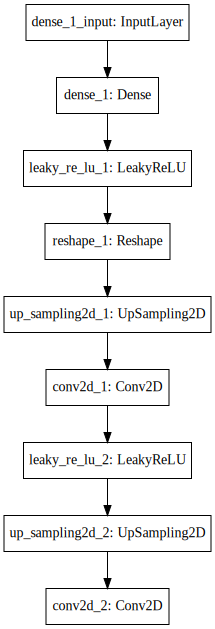

In [2]:
nb_filter = 200

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100

# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((128, 7, 7)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()
SVG(model_to_dot(generator).create(prog='dot', format='svg'))

# Discriminator Network

Our next order of business will be defining a *discriminator* model. Recall a discriminator $\mathcal{D}: \mathbb{R}^{\text{H} \times \text{W} \times \text{C}} \rightarrow \mathbb{R}$ maps an image $\mathbf{X} \in \mathbb{R}^{\text{H} \times \text{W} \times \text{C}}$ to a probability $p \in \mathbb{R}$ that $\mathbf{X}$ came from the data distribution and **not** the generator. We can visualize $\mathcal{D}$ as the computational graph

<img src="images/Fancy D.svg" alt="Discriminator" style="width: 300px;"/>

and as with $\mathcal{G}$, we will model $\mathcal{D}$ as a neural network.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 14, 14)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 14, 14)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 7, 7)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128, 7, 7)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 7, 7)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

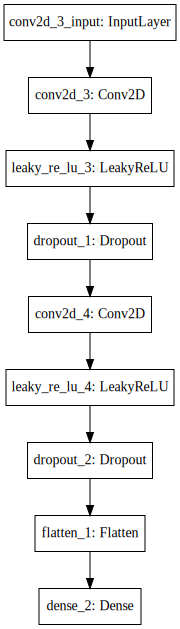

In [3]:
# Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1, 28, 28), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()
SVG(model_to_dot(discriminator).create(prog='dot', format='svg'))

# Sample From $\mathcal{G}$

Even though $\mathcal{G}$ is not very good at generating realistic images, we can sample from it to get an idea of the kinds of images it is generating right now. Let's do that now.

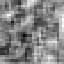

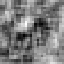

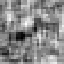

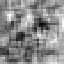

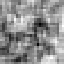

In [4]:
from IPython.display import display
import numpy as np
from keras.preprocessing.image import array_to_img

nb_sample = 5

z = np.random.uniform(size=[nb_sample, 100])
X_fake = generator.predict(z)
imgs = [array_to_img(x) for x in X_fake]
imgs = [img.resize(size=[64, 64]) for img in imgs]

for img in imgs:
    display(img)

# Load MNIST Data

For this lab, we will be using the MNIST dataset to train our GAN to produce realistic images of handwritten digits. So the first thing we need to do is load the data!

44251


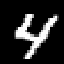

50106


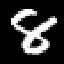

23399


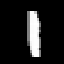

4681


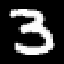

1139


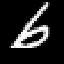

In [5]:
from IPython.display import display
import numpy as np
from keras.datasets import mnist
from keras.preprocessing.image import array_to_img
from keras.utils import np_utils

# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5 #this is whitening
X_train = X_train[:, np.newaxis, :, :]

nb_mnist = len(X_train)
for idx in np.random.choice(nb_mnist, size=5, replace=False):
    print(idx)
    x = X_train[idx]
    #print(x.shape)
    img = array_to_img(x).resize(size=[64, 64])
    display(img)

# Pretrain $\mathcal{D}$

One trick for making training GANs easier is to *pretrain* the discriminator $\mathcal{D}$. The intuition behind this is that $\mathcal{G}$ will be able to learn to generate realistic images more quickly if $\mathcal{D}$ already knows the difference between real and fake images.

In [9]:
y

array([ 1.,  1.,  1., ...,  0.,  0.,  0.])

In [6]:
from keras.utils.np_utils import to_categorical

nb_sample = 1000

z = np.random.uniform(size=[nb_sample, 100])
X_fake = generator.predict(z)

y_real, y_fake = np.ones(nb_sample), np.zeros(nb_sample)
X, y = np.concatenate([X_train[:nb_sample], X_fake]), np.concatenate([y_real, y_fake])
y[nb_sample:] = 0


discriminator.fit(X, y, epochs=1)

Epoch 1/1
2000/2000 [==============================] - 6s - loss: 0.2702     


# Generative Adversarial Network

Now that we have a generator and a discriminator, let's string them together to make a *generative adversarial network*. Recall that a generative adversarial network $\mathcal{A} = D \circ G$ can be visualized by the computational graph

<img src="images/Fancy GAN.svg" alt="GAN" style="width: 300px;"/>

and consists of a generator $\mathcal{G}$ whose goal is to produce synthetic images $\widetilde{\mathbf{X}} \in \mathbb{R}^{\times \text{W} \times \text{H} \times \text{C}}$, which are realistic enough to fool $\mathcal{D}$ into predicting a value of $p \in \mathbb{R}$ close to 1.0.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1, 28, 28)         839937    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 212865    
Total params: 1,052,802
Trainable params: 839,937
Non-trainable params: 212,865
_________________________________________________________________


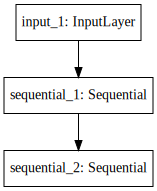

In [7]:
# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()
SVG(model_to_dot(gan).create(prog='dot', format='svg'))

## Helper Functions

We'll want to define a few helper functions to get things going nicely.

In [8]:
# Plot the loss from each batch
def plot_loss(epoch, g_losses, d_losses):
    plt.figure(figsize=(10, 8))
    plt.plot(d_losses, label='Discriminitive loss')
    plt.plot(g_losses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./images/dcgan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plot_generated_images(generator, epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('./images/dcgan_generated_image_epoch_%d.png' % epoch)

# Save the generator and discriminator networks (and weights) for later use
def save_models(epoch):
    generator.save('./models/dcgan_generator_epoch_%d.h5' % epoch)
    discriminator.save('./models/dcgan_discriminator_epoch_%d.h5' % epoch)

# Train $\mathcal{A}$

We now have all of the pieces in place to optimize $\mathcal{A}$! The core algorithm of training a GAN can be visualized as

<img src="images/GAN Loop.svg" alt="Drawing" style="width: 600px;"/>

where **;** implies concatenation. If you feel ready to implement this algorithm, then skip down to the last empty code cell and start coding! Otherwise, there is a full description at the bottom of this notebook to assist your understanding and the previous code cells will allow you to build up to the full solution.

# Detailed Description of Training Algorithm

The training algorithm pictured above can be more understood in more detail as

1. Sample a random $\mathbf{z}$ minibatch and predict $\widetilde{\mathbf{X}} = \mathcal{G}(\mathbf{z})$
2. Sample a $\mathbf{X}$ minibatch
3. Compute $\nabla_{\theta_\mathcal{D}}$ on $([\widetilde{\mathbf{X}} ; \mathbf{X}], [\mathbf{0} ; \mathbf{1}])$ and use it to step $\theta_\mathcal{D}$
4. Freeze $\theta_\mathcal{D}$
5. Compute $\nabla_{\theta_\mathcal{G}}$ on $(\widetilde{\mathbf{X}}, \mathbf{1})$ and step $\theta_\mathcal{G}$
6. Unfreeze $\theta_\mathcal{D}$
7. Go to step 1

In steps 1 and 2, we are simply generating a batch of fake and real images $\widetilde{\mathbf{X}}$ and $\mathbf{X}$. 

In step 3, we are making an update to $\theta_\mathcal{D}$ (e.g. with SGD) so that $\mathcal{D}$ does a little better at telling $\widetilde{\mathbf{X}}$ from $\mathbf{X}$. To accomplish this, we simply pass in the labeled pair $([\widetilde{\mathbf{X}} ; \mathbf{X}], [\mathbf{0} ; \mathbf{1}])$ and compute $\nabla_{\theta_\mathcal{D}}$ via backpropagation. We are now done updating $\theta_\mathcal{D}$ for this round, so we freeze $\theta_\mathcal{D}$ in Step 4.

Now comes the trickiest part of the entire procedure, which takes some explanation.

In Step 5, our goal is to update the $\mathcal{G}$'s weights so they will make $\widetilde{\mathbf{X}}$ a little more realistic. Note that $\nabla_{\theta_\mathcal{G}}$ for the "true" labeling $(\widetilde{\mathbf{X}}, \mathbf{0})$ (as seen in step 3 via backpropagation) tells us how to change $\theta_\mathcal{G}$ so that $\widetilde{\mathbf{X}}$ is a little *less* realistic (i.e. $\mathcal{A}$'s loss would decrease, thus improving $\mathcal{A}$'s accuracy). Since we want to do the opposite (i.e. decreasing $\mathcal{A}$'s accuracy by increasing $\mathcal{A}$'s loss), we pass in an "adversarial" labeling. This will make $\widetilde{\mathbf{X}}$ a little *more* realistic as $\mathcal{A}$'s loss will increase. We compute $\nabla_{\theta_\mathcal{G}}$ via backpropagation with this input pair and step $\theta_\mathcal{G}$ (e.g. with SGD).

In Step 6, we are done updating $\theta_\mathcal{G}$ so we unfreeze $\theta_\mathcal{D}$.

Finally, we go back to Step 1, thus entering the next round.

In [ ]:
### Your code here









In [9]:
d_losses = []
g_losses = []

def train(epochs=1, batchSize=128):
    batchCount = int(np.floor(X_train.shape[0] / batchSize))
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print( 'Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15) # just prints a separator
        for _ in bar(range(batchCount)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        d_losses.append(dloss)
        g_losses.append(gloss)

        if e == 1 or e % 5 == 0:
            plot_generated_images(generator, e)
            save_models(e)

    # Plot series of losses
    plot_loss(e, g_losses, d_losses)

In [10]:
train(1, 256)

Epochs: 1
Batch size: 256
Batches per epoch: 234
--------------- Epoch 1 ---------------


  5% ( 14 of 234) |########                                                                                                                                             | Elapsed Time: 0:01:34 ETA: 0:23:53

KeyboardInterrupt: 